Using cpu device
Model accuracy: 85.28%


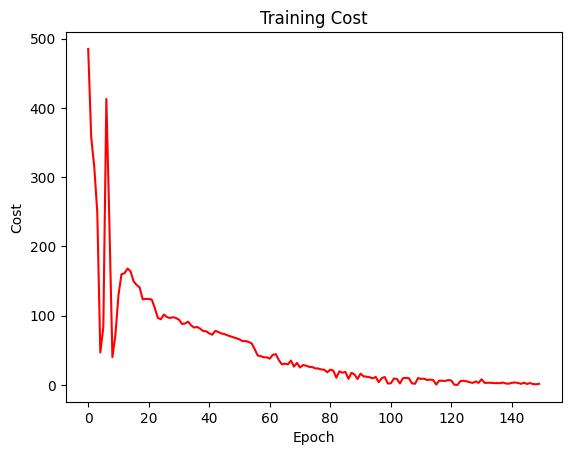

In [1]:
import os
import torch
import pandas as pd

from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
import matplotlib.pyplot as plt

# Read data, convert to NumPy arrays
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:3].values
y = data.iloc[:, 3].values

# convert into PyTorch tensors
trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

#Use cuda y/n
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

#Neural Network construction
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs):  
        super().__init__() 
        # Simple linear connections
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 36),
            nn.ReLU(),
            nn.Linear(36, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 1),
            # nn.ReLU()
        )           
    def forward(self, x): 
        return self.linear_relu_stack(x)
    
# Training

epochs = 150
learningRate = 0.0001

# Simplest possible network: 9 inputs and 1 output (binary: 0 when < 0.5 and 1 when > 0.5)
model = NeuralNetwork(3, 1)

losses = []
lossFunction = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.SGD(model.parameters(), lr=learningRate)

added = False

for i in range(epochs):  
    added = False  
    for x, y in zip(trainingSetX, trainingSetY): 
        # Reset the gradient delta's (dw, db)
        gradientDescent.zero_grad()
        yhat = model(x)
        loss = lossFunction(yhat, y)     
        if not added:
            added = True
            # Keep track of loss
            losses.append(loss.item())
        # Apply gradient descent (via backpropagation)
        loss.backward()
        # Use w += -step * dw * learnRate
        gradientDescent.step()

# evaluate accuracy after training
model.eval()
y_pred = model(trainingSetX)
acc = (y_pred.round() == trainingSetY).float().mean()
acc = float(acc)
print("Model accuracy: %.2f%%" % (acc*100))

with open('SDCar_Sonar.pth', 'wb') as f:
    torch.save(model.linear_relu_stack, f)

# Compare
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(epochs)], losses, 'red')
plt.show()
